## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# RMSLE metric - Competition evaluation
def rmsle(y_true, y_pred):
    """Root Mean Squared Logarithmic Error"""
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

plt.rcParams['figure.figsize'] = (14, 6)
sns.set_style('whitegrid')

print("✓ Libraries imported!")

✓ Libraries imported!


## Q1. Examine dataset size, missing values, and feature types.

In [4]:
train_df = pd.read_csv('bike_train.csv')
test_df = pd.read_csv('bike_test.csv')

print("\n1. DATASET SIZE:")
print(f"   Training samples: {train_df.shape[0]:,}")
print(f"   Test samples: {test_df.shape[0]:,}")
print(f"   Total features (train): {train_df.shape[1]}")
print(f"   Features for modeling: {train_df.shape[1] - 1} (excluding target 'count')")

print("\n2. MISSING VALUES:")
missing_train = train_df.isnull().sum()
if missing_train.sum() == 0:
    print("   ✓ No missing values in training data")
else:
    print(missing_train[missing_train > 0])

print("\n3. FEATURE TYPES:")
print(train_df.dtypes)

print("\n4. DATASET INFO:")
train_df.info()

print("\n5. STATISTICAL SUMMARY:")
train_df.describe()


1. DATASET SIZE:
   Training samples: 10,450
   Test samples: 2,613
   Total features (train): 12
   Features for modeling: 11 (excluding target 'count')

2. MISSING VALUES:
   ✓ No missing values in training data

3. FEATURE TYPES:
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

4. DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10450 non-null  object 
 1   season      10450 non-null  int64  
 2   holiday     10450 non-null  int64  
 3   workingday  10450 non-null  int64  
 4   weather     10450 non-null  int64  
 5   temp        10450 non-null  float64
 6   atemp       10450 non-null  

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000
mean,2.507943,0.028804,0.675694,1.413876,20.191700,23.605793,61.924211,12.765259,35.869091,154.511675,190.410526
std,1.116946,0.167263,0.468137,0.632258,7.792683,8.478045,19.245193,8.102821,49.629436,150.861267,181.038755
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,35.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.450050,16.000000,117.000000,143.000000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,49.000000,221.000000,283.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


# Q2. Visualize relationships between key features and the target variable (count).

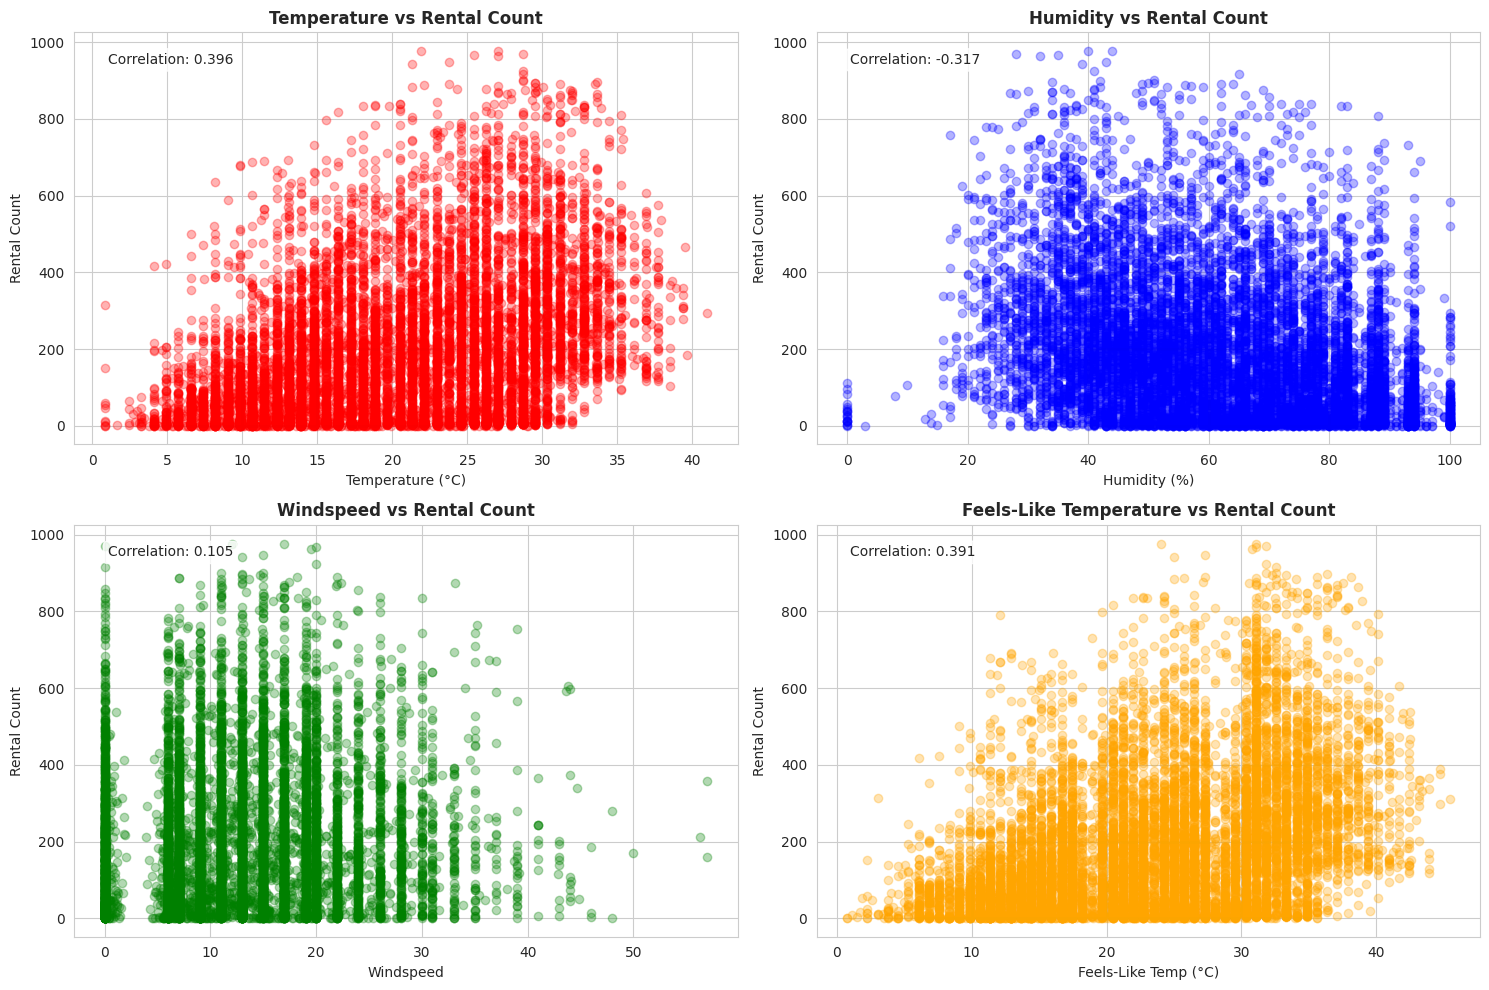

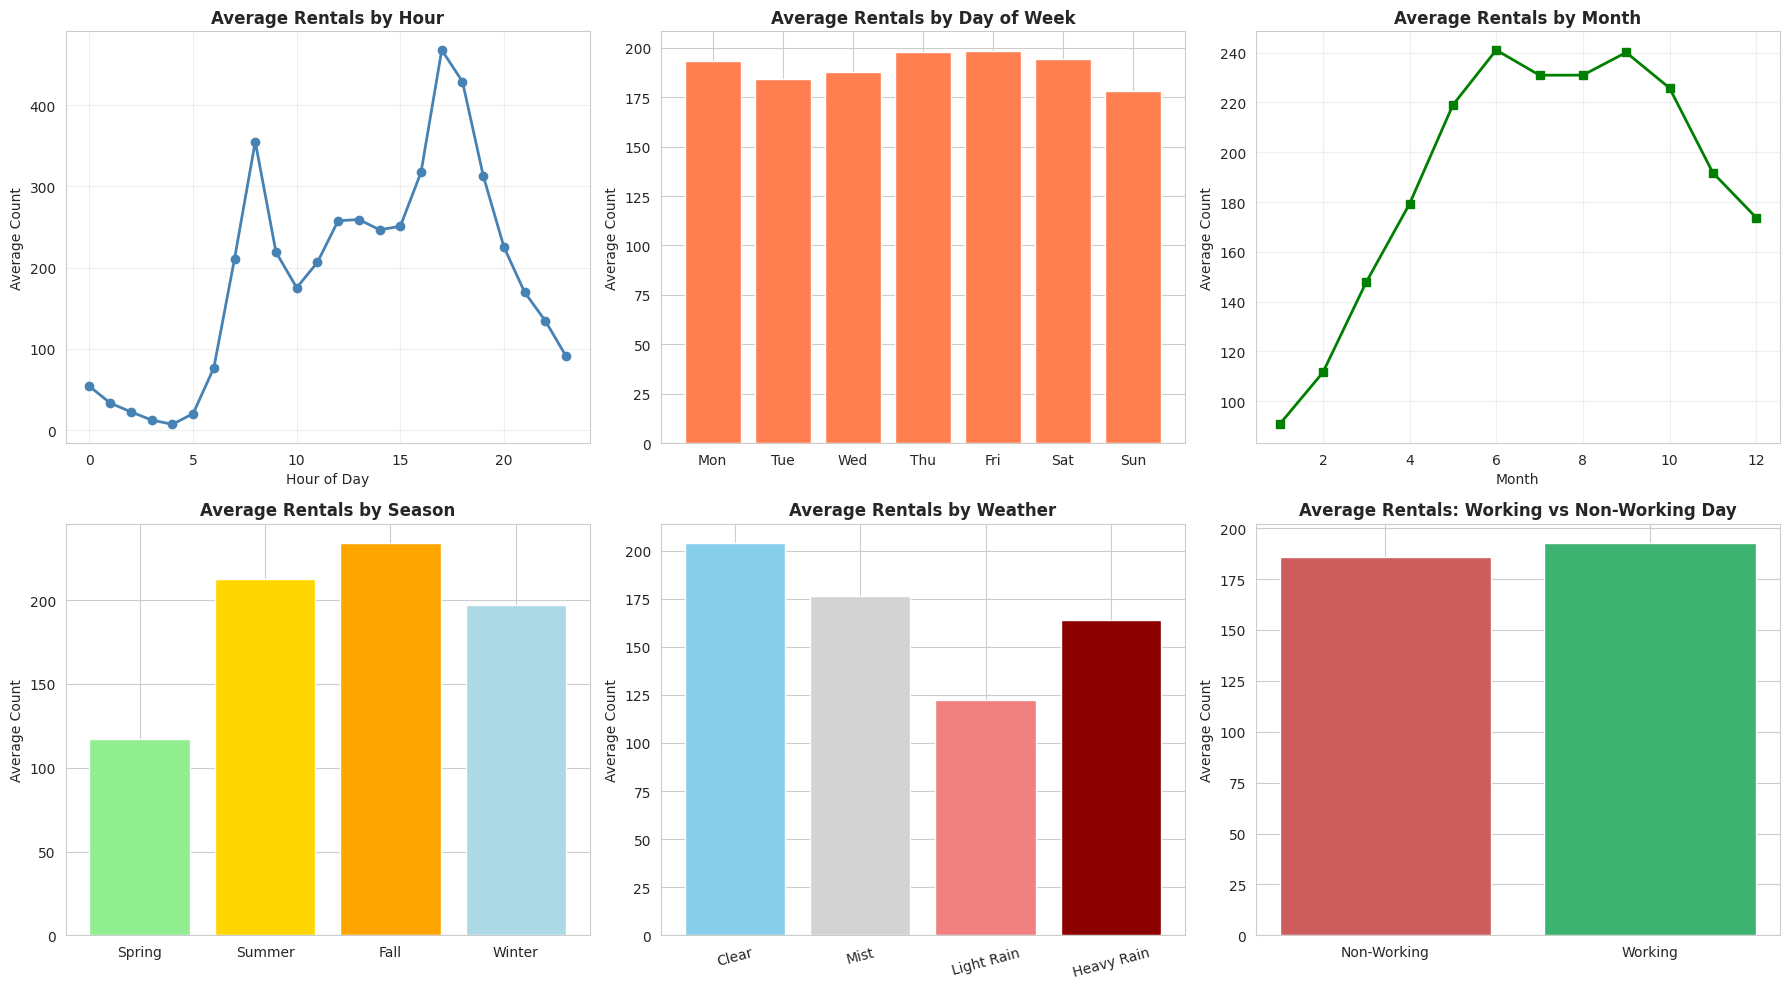


✓ Categorical and temporal relationships visualized


In [7]:
# Parse datetime first for temporal analysis
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
train_df['hour'] = train_df['datetime'].dt.hour
train_df['month'] = train_df['datetime'].dt.month
train_df['dayofweek'] = train_df['datetime'].dt.dayofweek

# 1. Continuous variables vs count
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(train_df['temp'], train_df['count'], alpha=0.3, color='red')
axes[0, 0].set_title('Temperature vs Rental Count', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Rental Count')
corr_temp = train_df['temp'].corr(train_df['count'])
axes[0, 0].text(0.05, 0.95, f'Correlation: {corr_temp:.3f}', 
                transform=axes[0, 0].transAxes, va='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[0, 1].scatter(train_df['humidity'], train_df['count'], alpha=0.3, color='blue')
axes[0, 1].set_title('Humidity vs Rental Count', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Humidity (%)')
axes[0, 1].set_ylabel('Rental Count')
corr_hum = train_df['humidity'].corr(train_df['count'])
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr_hum:.3f}', 
                transform=axes[0, 1].transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[1, 0].scatter(train_df['windspeed'], train_df['count'], alpha=0.3, color='green')
axes[1, 0].set_title('Windspeed vs Rental Count', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Windspeed')
axes[1, 0].set_ylabel('Rental Count')
corr_wind = train_df['windspeed'].corr(train_df['count'])
axes[1, 0].text(0.05, 0.95, f'Correlation: {corr_wind:.3f}', 
                transform=axes[1, 0].transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[1, 1].scatter(train_df['atemp'], train_df['count'], alpha=0.3, color='orange')
axes[1, 1].set_title('Feels-Like Temperature vs Rental Count', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Feels-Like Temp (°C)')
axes[1, 1].set_ylabel('Rental Count')
corr_atemp = train_df['atemp'].corr(train_df['count'])
axes[1, 1].text(0.05, 0.95, f'Correlation: {corr_atemp:.3f}', 
                transform=axes[1, 1].transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Hour of day
hourly_avg = train_df.groupby('hour')['count'].mean()
axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, color='steelblue')
axes[0, 0].set_title('Average Rentals by Hour', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average Count')
axes[0, 0].grid(True, alpha=0.3)

# Day of week
dow_avg = train_df.groupby('dayofweek')['count'].mean()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), dow_avg.values, color='coral')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(dow_labels)
axes[0, 1].set_title('Average Rentals by Day of Week', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Average Count')

# Month
monthly_avg = train_df.groupby('month')['count'].mean()
axes[0, 2].plot(monthly_avg.index, monthly_avg.values, marker='s', linewidth=2, color='green')
axes[0, 2].set_title('Average Rentals by Month', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Month')
axes[0, 2].set_ylabel('Average Count')
axes[0, 2].grid(True, alpha=0.3)

# Season
season_avg = train_df.groupby('season')['count'].mean()
season_labels = ['Spring', 'Summer', 'Fall', 'Winter']
axes[1, 0].bar(range(1, 5), season_avg.values, 
               color=['lightgreen', 'gold', 'orange', 'lightblue'])
axes[1, 0].set_xticks(range(1, 5))
axes[1, 0].set_xticklabels(season_labels)
axes[1, 0].set_title('Average Rentals by Season', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average Count')

# Weather
weather_avg = train_df.groupby('weather')['count'].mean()
weather_labels = ['Clear', 'Mist', 'Light Rain', 'Heavy Rain']
axes[1, 1].bar(weather_avg.index, weather_avg.values, 
               color=['skyblue', 'lightgray', 'lightcoral', 'darkred'])
axes[1, 1].set_xticks(range(1, 5))
axes[1, 1].set_xticklabels(weather_labels, rotation=15)
axes[1, 1].set_title('Average Rentals by Weather', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Average Count')

# Working day
workingday_avg = train_df.groupby('workingday')['count'].mean()
axes[1, 2].bar([0, 1], workingday_avg.values, color=['indianred', 'mediumseagreen'])
axes[1, 2].set_xticks([0, 1])
axes[1, 2].set_xticklabels(['Non-Working', 'Working'])
axes[1, 2].set_title('Average Rentals: Working vs Non-Working Day', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Average Count')

plt.tight_layout()
plt.show()

print("\n✓ Categorical and temporal relationships visualized")

# Q3. Suggest which variables are likely to be most informative.

In [10]:
correlation_features = ['season', 'holiday', 'workingday', 'weather', 'temp', 
                        'atemp', 'humidity', 'windspeed', 'hour', 'month', 'count']

plt.figure(figsize=(12, 10))
correlation_matrix = train_df[correlation_features].corr()
print("\n✓ Correlation heatmap created")
print("\nTop correlations with target (count):")
print(correlation_matrix['count'].sort_values(ascending=False))


✓ Correlation heatmap created

Top correlations with target (count):
count         1.000000
hour          0.404188
temp          0.396451
atemp         0.390642
month         0.165475
season        0.160333
windspeed     0.105318
workingday    0.017361
holiday      -0.005615
weather      -0.124402
humidity     -0.316607
Name: count, dtype: float64


<Figure size 1200x1000 with 0 Axes>

# As shown in correlation matrix ith target "count" below is rank of each features

1. Hour of Day", "Strongest predictor - captures commute patterns and time-based demand

2. Temperature (temp, atemp)", "Strong positive correlation - people rent more in comfortable weather

3. Month/Season", "Captures seasonal trends and long-term patterns

4. Weather Condition", "Clear weather increases demand, rain decreases it significantly

5. Working Day", "Distinguishes weekday commute patterns from weekend leisure patterns

6. Humidity", "Moderate negative impact on rental behavior

7. Windspeed", "Weak but relevant - extreme wind discourages biking

8. Holiday", "Weak correlation but may interact with other features

## Q4. You can try to derive features from datetime (hour, weekday, month, season), encode categorical variables, consider transformations to capture nonlinear trends to improve your model performance. If you do any of these, report it as answer to Q4. It is optional.

In [14]:
def extract_features(df):
   
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'], format='mixed', dayfirst=True)
    
    # Temporal features
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_peak_hour'] = (df['hour'].isin([7, 8, 17, 18])).astype(int)
    
    # Time of day
    df['is_morning'] = ((df['hour'] >= 6) & (df['hour'] < 12)).astype(int)
    df['is_afternoon'] = ((df['hour'] >= 12) & (df['hour'] < 18)).astype(int)
    df['is_evening'] = ((df['hour'] >= 18) & (df['hour'] < 22)).astype(int)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] < 6)).astype(int)
    
    return df

train_df = extract_features(train_df)
test_df = extract_features(test_df)

print("\n3. FEATURE TYPES:")
print(train_df.dtypes)
print("✓ Features engineered")


3. FEATURE TYPES:
datetime        datetime64[ns]
season                   int64
holiday                  int64
workingday               int64
weather                  int64
temp                   float64
atemp                  float64
humidity                 int64
windspeed              float64
casual                   int64
registered               int64
count                    int64
hour                     int32
month                    int32
dayofweek                int32
year                     int32
day                      int32
is_weekend               int64
is_peak_hour             int64
is_morning               int64
is_afternoon             int64
is_evening               int64
is_night                 int64
dtype: object
✓ Features engineered


## Features

In [17]:
features = [
    'season', 'holiday', 'workingday', 'weather',
    'temp', 'atemp', 'humidity', 'windspeed',
    'hour', 'dayofweek', 'month', 'year',
    'is_weekend', 'is_peak_hour',
    'is_morning', 'is_afternoon', 'is_evening', 'is_night'
]

X = train_df[features]
y = train_df['count']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape[0]:,} | Validation: {X_val.shape[0]:,}")
print(f"Features: {len(features)}")

Train: 8,360 | Validation: 2,090
Features: 18


## Q5. Split data into training and validation sets and build a simple Linear Regression model.

In [20]:
print(f"\n1. DATA SPLIT:")
print(f"   Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features used: {len(features)}")

print(f"\n2. FEATURES:")
for i, feat in enumerate(features, 1):
    print(f"   {i:2d}. {feat}")


print(f"\n3. TRAINING LINEAR REGRESSION MODEL...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


y_pred_train = lr_model.predict(X_train)
y_pred_val = lr_model.predict(X_val)


train_rmsle = rmsle(y_train, y_pred_train)
val_rmsle = rmsle(y_val, y_pred_val)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)

print(f"\n4. MODEL PERFORMANCE:")
print(f"   {'Metric':<20} {'Training':<15} {'Validation':<15}")
print(f"   {'-'*50}")
print(f"   {'RMSLE (Primary)':<20} {train_rmsle:<15.4f} {val_rmsle:<15.4f} ⭐")
print(f"   {'RMSE':<20} {train_rmse:<15.2f} {val_rmse:<15.2f}")
print(f"   {'R² Score':<20} {train_r2:<15.4f} {val_r2:<15.4f}")

print("✓ Simple Linear Regression model trained successfully")



1. DATA SPLIT:
   Training set: 8,360 samples (80.0%)
   Validation set: 2,090 samples (20.0%)
   Features used: 18

2. FEATURES:
    1. season
    2. holiday
    3. workingday
    4. weather
    5. temp
    6. atemp
    7. humidity
    8. windspeed
    9. hour
   10. dayofweek
   11. month
   12. year
   13. is_weekend
   14. is_peak_hour
   15. is_morning
   16. is_afternoon
   17. is_evening
   18. is_night

3. TRAINING LINEAR REGRESSION MODEL...

4. MODEL PERFORMANCE:
   Metric               Training        Validation     
   --------------------------------------------------
   RMSLE (Primary)      1.2284          1.1992          ⭐
   RMSE                 109.06          108.66         
   R² Score             0.6370          0.6401         
✓ Simple Linear Regression model trained successfully


## Q6. To improve model performance, you may try to:
  Extend feature space using polynomial transformations (degree 2 or 3)                   

  Apply Ridge and Lasso regression on polynomial features, Tune the regularization strength (α).

In [23]:
# Standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


all_models = {} # For Storing All Model Results


all_models['Linear Regression'] = {
    'train_rmsle': train_rmsle,
    'val_rmsle': val_rmsle,
    'val_rmse': val_rmse,
    'val_r2': val_r2,
    'model': lr_model,
    'alpha': None
}

print("\n. POLYNOMIAL FEATURES:")
print("   Testing degree 2 and degree 3 transformations...")

# Test polynomial degrees
for degree in [2, 3]:
    print(f"\n   {'='*70}")
    print(f"   Polynomial Degree: {degree}")
    print(f"   {'='*70}")
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly = poly.transform(X_val_scaled)
    
    print(f"   Original features: {X_train_scaled.shape[1]}")
    print(f"   Polynomial features: {X_train_poly.shape[1]}")
    
    if degree == 2:
        param_polly_degree2 = X_train_poly.shape[1]
    else :
        param_polly_degree3 = X_train_poly.shape[1]

 
    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train)
    
    y_pred_train_lr = lr_poly.predict(X_train_poly)
    y_pred_val_lr = lr_poly.predict(X_val_poly)
    
    train_rmsle_lr = rmsle(y_train, y_pred_train_lr)
    val_rmsle_lr = rmsle(y_val, y_pred_val_lr)
    val_rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_val_lr))
    val_r2_lr = r2_score(y_val, y_pred_val_lr)
    
    print(f"\n   A) Linear Regression (Poly {degree}):")
    print(f"      Train RMSLE: {train_rmsle_lr:.4f}, Val RMSLE: {val_rmsle_lr:.4f} ")
    
    all_models[f'Linear Reg (Poly {degree})'] = {
        'train_rmsle': train_rmsle_lr,
        'val_rmsle': val_rmsle_lr,
        'val_rmse': val_rmse_lr,
        'val_r2': val_r2_lr,
        'model': lr_poly,
        'poly': poly,
        'alpha': None
    }
    
    
    print(f"\n   B) Ridge Regression (Poly {degree}):")
    print(f"      Tuning α: [0.001, 0.01, 0.1, 1, 10, 100, 1000]")
    
    alpha_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    best_ridge_alpha = None
    best_ridge_rmsle = float('inf')
    best_ridge_model = None
    
    for alpha in alpha_values:
        ridge = Ridge(alpha=alpha, random_state=42)
        ridge.fit(X_train_poly, y_train)
        y_pred_val_ridge = ridge.predict(X_val_poly)
        val_rmsle_ridge = rmsle(y_val, y_pred_val_ridge)
        
        if val_rmsle_ridge < best_ridge_rmsle:
            best_ridge_rmsle = val_rmsle_ridge
            best_ridge_alpha = alpha
            best_ridge_model = ridge
    
    y_pred_train_ridge = best_ridge_model.predict(X_train_poly)
    y_pred_val_ridge = best_ridge_model.predict(X_val_poly)
    
    print(f"      Best α: {best_ridge_alpha}")
    print(f"      Train RMSLE: {rmsle(y_train, y_pred_train_ridge):.4f}, Val RMSLE: {best_ridge_rmsle:.4f} ")
    
    all_models[f'Ridge (Poly {degree})'] = {
        'train_rmsle': rmsle(y_train, y_pred_train_ridge),
        'val_rmsle': best_ridge_rmsle,
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_pred_val_ridge)),
        'val_r2': r2_score(y_val, y_pred_val_ridge),
        'model': best_ridge_model,
        'poly': poly,
        'alpha': best_ridge_alpha
    }
    
    # C) Lasso Regression with Hyperparameter Tuning
    print(f"\n   C) Lasso Regression (Poly {degree}):")
    print(f"      Tuning α: [0.001, 0.01, 0.1, 1, 10, 100, 1000]")
    
    best_lasso_alpha = None
    best_lasso_rmsle = float('inf')
    best_lasso_model = None
    
    for alpha in alpha_values:
        lasso = Lasso(alpha=alpha, random_state=42, max_iter=10000)
        lasso.fit(X_train_poly, y_train)
        y_pred_val_lasso = lasso.predict(X_val_poly)
        val_rmsle_lasso = rmsle(y_val, y_pred_val_lasso)
        
        if val_rmsle_lasso < best_lasso_rmsle:
            best_lasso_rmsle = val_rmsle_lasso
            best_lasso_alpha = alpha
            best_lasso_model = lasso
    
    y_pred_train_lasso = best_lasso_model.predict(X_train_poly)
    y_pred_val_lasso = best_lasso_model.predict(X_val_poly)
    non_zero_coefs = np.sum(best_lasso_model.coef_ != 0)
    
    print(f"      Best α: {best_lasso_alpha}")
    print(f"      Train RMSLE: {rmsle(y_train, y_pred_train_lasso):.4f}, Val RMSLE: {best_lasso_rmsle:.4f} ")
    print(f"      Non-zero features: {non_zero_coefs}/{len(best_lasso_model.coef_)}")
    
    all_models[f'Lasso (Poly {degree})'] = {
        'train_rmsle': rmsle(y_train, y_pred_train_lasso),
        'val_rmsle': best_lasso_rmsle,
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_pred_val_lasso)),
        'val_r2': r2_score(y_val, y_pred_val_lasso),
        'model': best_lasso_model,
        'poly': poly,
        'alpha': best_lasso_alpha,
        'active_features': non_zero_coefs
    }




. POLYNOMIAL FEATURES:
   Testing degree 2 and degree 3 transformations...

   Polynomial Degree: 2
   Original features: 18
   Polynomial features: 189

   A) Linear Regression (Poly 2):
      Train RMSLE: 0.9890, Val RMSLE: 0.9709 

   B) Ridge Regression (Poly 2):
      Tuning α: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
      Best α: 100
      Train RMSLE: 0.9611, Val RMSLE: 0.9396 

   C) Lasso Regression (Poly 2):
      Tuning α: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
      Best α: 10
      Train RMSLE: 0.9260, Val RMSLE: 0.8891 
      Non-zero features: 30/189

   Polynomial Degree: 3
   Original features: 18
   Polynomial features: 1329

   A) Linear Regression (Poly 3):
      Train RMSLE: 0.7450, Val RMSLE: 0.7547 

   B) Ridge Regression (Poly 3):
      Tuning α: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
      Best α: 1000
      Train RMSLE: 0.7187, Val RMSLE: 0.7175 

   C) Lasso Regression (Poly 3):
      Tuning α: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
      Best α: 1
      Train RMSLE

## Q7. Summarize all results (of different models tried out) in one table (RMSLE, key observations).

In [26]:
comparison_data = []
for model_name, results in all_models.items():
    row = {
        'Model': model_name,
        'Train RMSLE': results['train_rmsle'],
        'Val RMSLE': results['val_rmsle'],
        'Val RMSE': results['val_rmse'],
        'Val R²': results['val_r2'],
        'Alpha (α)': results['alpha'] if results['alpha'] is not None else 'N/A'
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Val RMSLE')

print("\n COMPREHENSIVE MODEL COMPARISON")
print("   Primary Metric: RMSLE (Root Mean Squared Logarithmic Error)")
print("   Lower RMSLE = Better Performance \n")
print(comparison_df.to_string(index=False))


best_idx = comparison_df['Val RMSLE'].idxmin()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_val_rmsle = comparison_df.loc[best_idx, 'Val RMSLE']

print("\n" + "="*80)
print(f" BEST MODEL: {best_model_name}")
print(f"   Validation RMSLE: {best_val_rmsle:.4f} ")
print("="*80)


print("\n KEY OBSERVATIONS:")
print("\n1. Baseline Performance:")
print(f"   Simple Linear Regression Val RMSLE: {all_models['Linear Regression']['val_rmsle']:.4f}")

print("\n2. Polynomial Features Impact:")
poly2_lr_rmsle = all_models.get('Linear Reg (Poly 2)', {}).get('val_rmsle', 'N/A')
poly3_lr_rmsle = all_models.get('Linear Reg (Poly 3)', {}).get('val_rmsle', 'N/A')
print(f"   Poly degree 2 improved RMSLE: {poly2_lr_rmsle if poly2_lr_rmsle != 'N/A' else 'N/A'}")
print(f"   Poly degree 3 improved RMSLE: {poly3_lr_rmsle if poly3_lr_rmsle != 'N/A' else 'N/A'}")

print("\n3. Regularization Effect:")
print("   Ridge and Lasso help prevent overfitting on polynomial features")
print("   Optimal α values vary by polynomial degree")

print("\n4. Model Ranking (by Val RMSLE):")
for i, (idx, row) in enumerate(comparison_df.head().iterrows(), 1):
    print(f"   {i}. {row['Model']:<30} RMSLE: {row['Val RMSLE']:.4f}")




 COMPREHENSIVE MODEL COMPARISON
   Primary Metric: RMSLE (Root Mean Squared Logarithmic Error)
   Lower RMSLE = Better Performance 

              Model  Train RMSLE  Val RMSLE   Val RMSE   Val R² Alpha (α)
     Lasso (Poly 3)     0.724693   0.707071  59.073180 0.893623         1
     Ridge (Poly 3)     0.718700   0.717516  57.533916 0.899095      1000
Linear Reg (Poly 3)     0.744988   0.754719  50.218037 0.923125       N/A
     Lasso (Poly 2)     0.926015   0.889139  86.191988 0.773535        10
     Ridge (Poly 2)     0.961099   0.939562  69.742983 0.851725       100
Linear Reg (Poly 2)     0.988960   0.970914  67.211143 0.862295       N/A
  Linear Regression     1.228354   1.199209 108.656752 0.640101       N/A

 BEST MODEL: Lasso (Poly 3)
   Validation RMSLE: 0.7071 

 KEY OBSERVATIONS:

1. Baseline Performance:
   Simple Linear Regression Val RMSLE: 1.1992

2. Polynomial Features Impact:
   Poly degree 2 improved RMSLE: 0.9709139640957454
   Poly degree 3 improved RMSLE: 0.75471

# Q8: RESIDUAL ANALYSIS FOR BEST MODEL


Best Model: Lasso (Poly 3)
Validation RMSLE: 0.7071



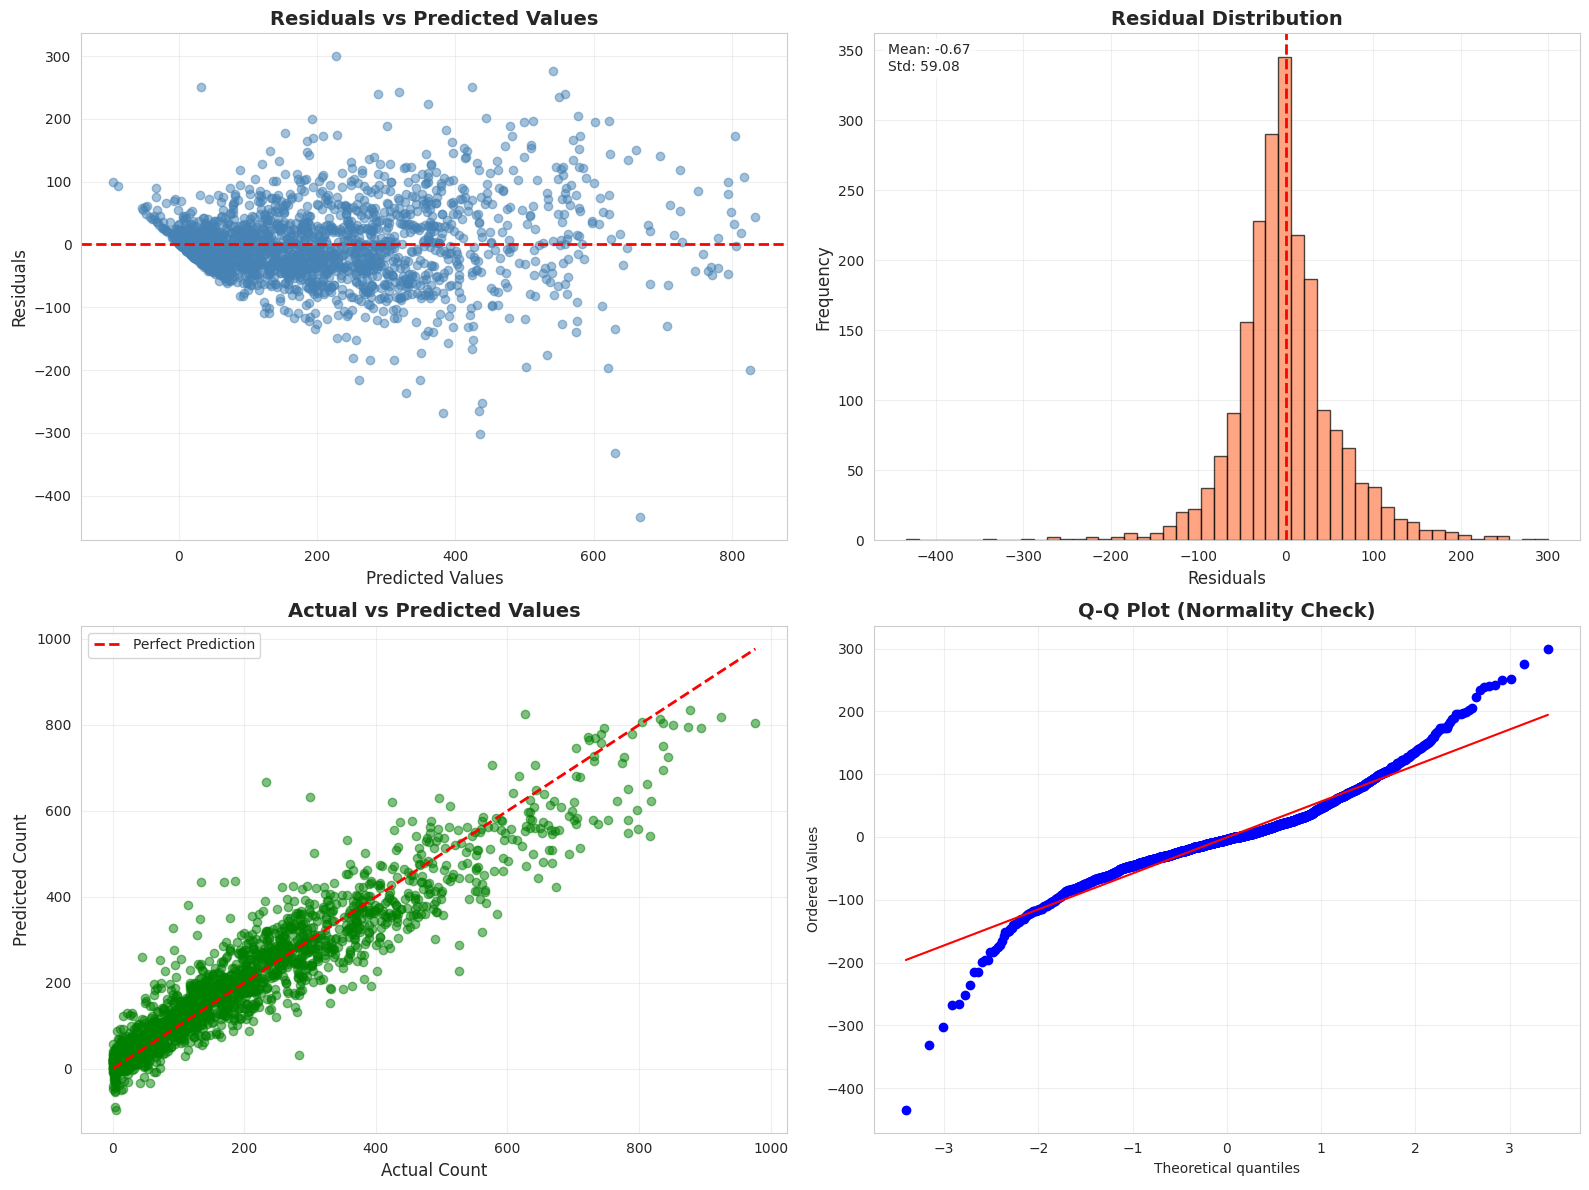


 RESIDUAL ANALYSIS SUMMARY:

1. Residual Statistics:
   Mean: -0.67 (should be close to 0)
   Std Dev: 59.08
   Min: -434.04
   Max: 299.44

2. Residual Patterns:
    Mean close to zero - no systematic bias

3. Homoscedasticity Check:
   Examining if variance is constant across predicted values
   (Look at 'Residuals vs Predicted' plot)

4. Normality Check:
   Q-Q plot shows if residuals follow normal distribution
   (Points close to diagonal line indicate normality)


In [29]:

best_model_info = all_models[best_model_name]
best_model = best_model_info['model']


if 'poly' in best_model_info:
    
    poly_transformer = best_model_info['poly']
    X_val_transformed = poly_transformer.transform(X_val_scaled)
    y_pred_best = best_model.predict(X_val_transformed)
else:
    
    y_pred_best = best_model.predict(X_val)


residuals = y_val - y_pred_best

print(f"\nBest Model: {best_model_name}")
print(f"Validation RMSLE: {best_val_rmsle:.4f}\n")


fig, axes = plt.subplots(2, 2, figsize=(16, 12))


axes[0, 0].scatter(y_pred_best, residuals, alpha=0.5, color='steelblue')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values', fontsize=12)
axes[0, 0].set_ylabel('Residuals', fontsize=12)
axes[0, 0].set_title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)


axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Residual Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)


mean_res = residuals.mean()
std_res = residuals.std()
axes[0, 1].text(0.02, 0.98, f'Mean: {mean_res:.2f}\nStd: {std_res:.2f}', 
                transform=axes[0, 1].transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


axes[1, 0].scatter(y_val, y_pred_best, alpha=0.5, color='green')
axes[1, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Count', fontsize=12)
axes[1, 0].set_ylabel('Predicted Count', fontsize=12)
axes[1, 0].set_title('Actual vs Predicted Values', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n RESIDUAL ANALYSIS SUMMARY:")
print(f"\n1. Residual Statistics:")
print(f"   Mean: {mean_res:.2f} (should be close to 0)")
print(f"   Std Dev: {std_res:.2f}")
print(f"   Min: {residuals.min():.2f}")
print(f"   Max: {residuals.max():.2f}")

print(f"\n2. Residual Patterns:")
if abs(mean_res) < 10:
    print("    Mean close to zero - no systematic bias")
else:
    print("    Mean not close to zero - potential bias")

print(f"\n3. Homoscedasticity Check:")
print("   Examining if variance is constant across predicted values")
print("   (Look at 'Residuals vs Predicted' plot)")

print(f"\n4. Normality Check:")
print("   Q-Q plot shows if residuals follow normal distribution")
print("   (Points close to diagonal line indicate normality)")



# Q9: WHY THE WINNING MODEL PERFORMS BETTER"

In [32]:
print(f"\n WINNING MODEL: {best_model_name}")
print(f"   Validation RMSLE: {best_val_rmsle:.4f} \n")


print("EXPLANATION OF SUPERIOR PERFORMANCE:")


reasons = []

if 'Poly' in best_model_name:
    degree = 2 if 'Poly 2' in best_model_name else 3
    reasons.append(
        ("1. Non-linear Feature Interactions",
         f"Polynomial degree {degree} captures non-linear relationships:",
         [
             "• Temperature² - captures optimal temperature ranges",
             "• Hour² - models peak commute times",
             "• temp X humidity - weather interaction effects",
             "• hour X workingday - commute pattern interactions",
             "These interactions cannot be learned by simple linear regression"
         ])
    )

if 'Ridge' in best_model_name:
    alpha_val = best_model_info['alpha']
    reasons.append(
        ("2. Ridge Regularization (L2)",
         f"Optimal α = {alpha_val} prevents overfitting:",
         [
             "• Shrinks large coefficients toward zero",
             "• Reduces model variance without excessive bias",
             "• Handles multicollinearity in polynomial features",
             "• Generalizes better to unseen data",
             f"• With {X_train_poly.shape[1] if 'poly' in best_model_info else X_train.shape[1]} features, regularization is crucial"
         ])
    )

if 'Lasso' in best_model_name:
    alpha_val = best_model_info['alpha']
    active_feats = best_model_info.get('active_features', 'N/A')
    reasons.append(
        ("2. Lasso Regularization (L1)",
         f"Optimal α = {alpha_val} performs automatic feature selection:",
         [
             "• Sets irrelevant feature coefficients to exactly zero",
             f"• Retained {active_feats} most important features",
             "• Reduces model complexity and improves interpretability",
             "• Prevents overfitting through sparsity",
             "• Focuses on strongest predictors only"
         ])
    )


baseline_rmsle = all_models['Linear Regression']['val_rmsle']
improvement = ((baseline_rmsle - best_val_rmsle) / baseline_rmsle) * 100

reasons.append(
    ("3. Performance Improvement",
     f"Compared to simple linear regression:",
     [
         f"• Baseline RMSLE: {baseline_rmsle:.4f}",
         f"• Best model RMSLE: {best_val_rmsle:.4f}",
         f"• Improvement: {improvement:.1f}% reduction in error",
         "• Better captures complex rental patterns",
         "• More robust predictions across all conditions"
     ])
)


for title, description, points in reasons:
    print(f"\n{title}")
    print(f"{description}")
    for point in points:
        print(f"   {point}")




 WINNING MODEL: Lasso (Poly 3)
   Validation RMSLE: 0.7071 

EXPLANATION OF SUPERIOR PERFORMANCE:

1. Non-linear Feature Interactions
Polynomial degree 3 captures non-linear relationships:
   • Temperature² - captures optimal temperature ranges
   • Hour² - models peak commute times
   • temp X humidity - weather interaction effects
   • hour X workingday - commute pattern interactions
   These interactions cannot be learned by simple linear regression

2. Lasso Regularization (L1)
Optimal α = 1 performs automatic feature selection:
   • Sets irrelevant feature coefficients to exactly zero
   • Retained 227 most important features
   • Reduces model complexity and improves interpretability
   • Prevents overfitting through sparsity
   • Focuses on strongest predictors only

3. Performance Improvement
Compared to simple linear regression:
   • Baseline RMSLE: 1.1992
   • Best model RMSLE: 0.7071
   • Improvement: 41.0% reduction in error
   • Better captures complex rental patterns
   

## Q10. Why does RMSLE penalize under-predictions more gently than RMSE?


 MATHEMATICAL COMPARISON:

Actual value: 100

Predicted    Error      RMSE Contrib    RMSLE Contrib   Ratio     
----------------------------------------------------------------------
50           -50        2500.00         0.4669          5354.56   
80           -20        400.00          0.0487          8214.25   
90           -10        100.00          0.0109          9199.33   
100          0          0.00            0.0000          0.00      
110          10         100.00          0.0089          11219.33  
120          20         400.00          0.0326          12254.28  
150          50         2500.00         0.1617          15457.66  


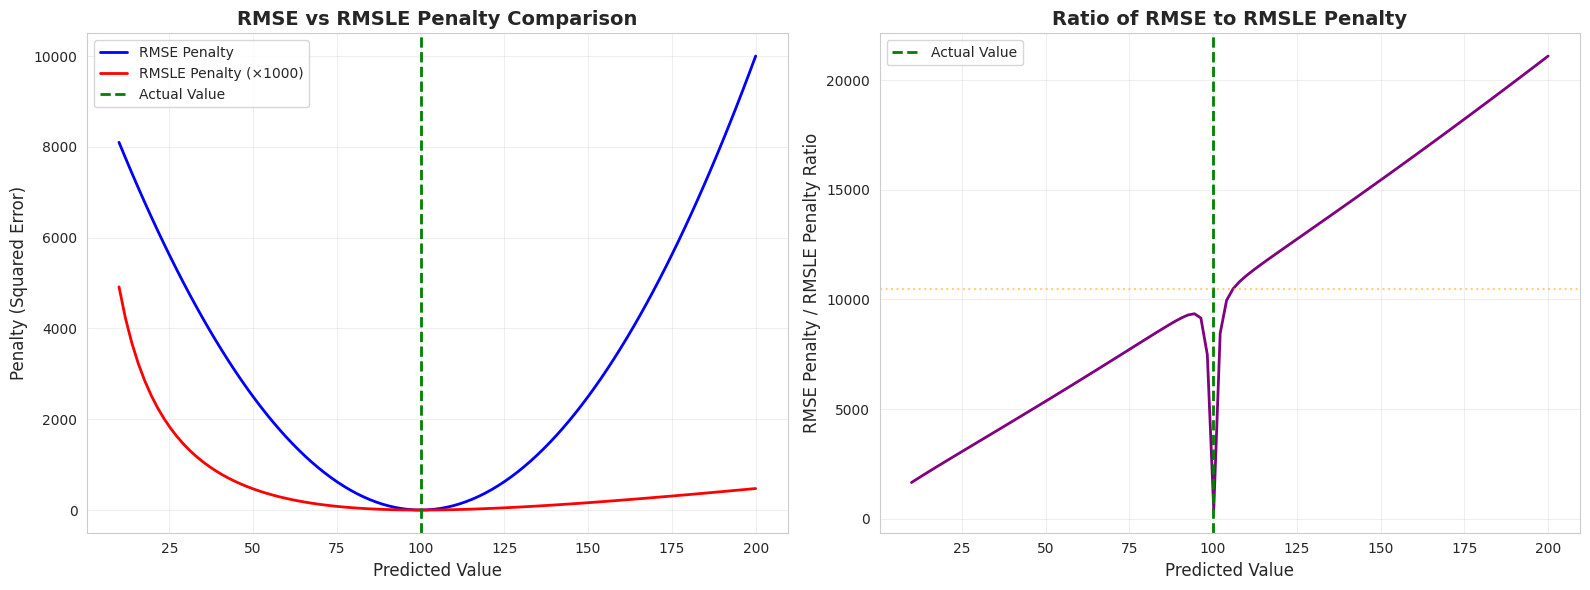

In [35]:
print("\n MATHEMATICAL COMPARISON:\n")


actual = 100
predictions = [50, 80, 90, 100, 110, 120, 150]  # Under to over predictions

print("Actual value: 100\n")
print(f"{'Predicted':<12} {'Error':<10} {'RMSE Contrib':<15} {'RMSLE Contrib':<15} {'Ratio':<10}")
print("-" * 70)

for pred in predictions:
    error = pred - actual
    rmse_contrib = (error)**2
    rmsle_contrib = (np.log1p(pred) - np.log1p(actual))**2
    ratio = rmse_contrib / rmsle_contrib if rmsle_contrib > 0 else 0
    
    print(f"{pred:<12} {error:<10} {rmse_contrib:<15.2f} {rmsle_contrib:<15.4f} {ratio:<10.2f}")


actual_val = 100
pred_range = np.linspace(10, 200, 100)

rmse_penalty = (pred_range - actual_val)**2
rmsle_penalty = (np.log1p(pred_range) - np.log1p(actual_val))**2

fig, axes = plt.subplots(1, 2, figsize=(16, 6))


axes[0].plot(pred_range, rmse_penalty, label='RMSE Penalty', linewidth=2, color='blue')
axes[0].plot(pred_range, rmsle_penalty * 1000, label='RMSLE Penalty (×1000)', linewidth=2, color='red')
axes[0].axvline(x=actual_val, color='green', linestyle='--', linewidth=2, label='Actual Value')
axes[0].set_xlabel('Predicted Value', fontsize=12)
axes[0].set_ylabel('Penalty (Squared Error)', fontsize=12)
axes[0].set_title('RMSE vs RMSLE Penalty Comparison', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


relative_penalty = rmse_penalty / (rmsle_penalty + 0.0001)  
axes[1].plot(pred_range, relative_penalty, linewidth=2, color='purple')
axes[1].axvline(x=actual_val, color='green', linestyle='--', linewidth=2, label='Actual Value')
axes[1].axhline(y=relative_penalty[50], color='orange', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Predicted Value', fontsize=12)
axes[1].set_ylabel('RMSE Penalty / RMSLE Penalty Ratio', fontsize=12)
axes[1].set_title('Ratio of RMSE to RMSLE Penalty', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



RMSLE penalizes under-predictions MORE than over-predictions, making it suitable for scenarios where under-estimation is more costly than over-estimation.

# Q11. What are the trade-offs between model simplicity and predictive power?

In [39]:

print("\n COMPARISON FROM OUR MODELS:\n")


tradeoff_data = []
for model_name, results in all_models.items():
    if 'Linear Regression' in model_name and 'Poly' not in model_name:
        complexity = 'Low'
        params = len(features )  # feature_columns
        interpretability = 'High'
    elif 'Poly 2' in model_name:
        complexity = 'Medium'
        params = param_polly_degree2  # degree 2 features
        interpretability = 'Medium'
    elif 'Poly 3' in model_name:
        complexity = 'High'
        params = param_polly_degree3  # degree 3 features
        interpretability = 'Low'
    else:
        complexity = 'Low'
        params = '18'
        interpretability = 'High'
    
    tradeoff_data.append({
        'Model': model_name,
        'Complexity': complexity,
        'Parameters': params,
        'Interpretability': interpretability,
        'Val RMSLE': results['val_rmsle'],
        'Train RMSLE': results['train_rmsle'],
        'Overfit Gap': results['train_rmsle'] - results['val_rmsle']
    })

tradeoff_df = pd.DataFrame(tradeoff_data)
tradeoff_df = tradeoff_df.sort_values('Complexity')

print(tradeoff_df.to_string(index=False))



 COMPARISON FROM OUR MODELS:

              Model Complexity  Parameters Interpretability  Val RMSLE  Train RMSLE  Overfit Gap
Linear Reg (Poly 3)       High        1329              Low   0.754719     0.744988    -0.009732
     Ridge (Poly 3)       High        1329              Low   0.717516     0.718700     0.001184
     Lasso (Poly 3)       High        1329              Low   0.707071     0.724693     0.017622
  Linear Regression        Low          18             High   1.199209     1.228354     0.029145
Linear Reg (Poly 2)     Medium         189           Medium   0.970914     0.988960     0.018046
     Ridge (Poly 2)     Medium         189           Medium   0.939562     0.961099     0.021536
     Lasso (Poly 2)     Medium         189           Medium   0.889139     0.926015     0.036875


# Q12. Why can’t Linear Regression alone capture time-of-day effects effectively?

In [42]:
hourly_avg = train_df.groupby('hour')['count'].mean()
print("Average bike rentals by hour:")
print(hourly_avg.to_string())

Average bike rentals by hour:
hour
0      54.100897
1      33.443956
2      22.640845
3      12.578313
4       7.329298
5      20.409292
6      76.652466
7     211.016317
8     355.095571
9     219.165533
10    175.290476
11    206.669746
12    257.793651
13    259.253394
14    246.665888
15    250.894231
16    317.461364
17    467.779736
18    428.909707
19    313.396355
20    225.469048
21    169.758465
22    134.555814
23     91.073497


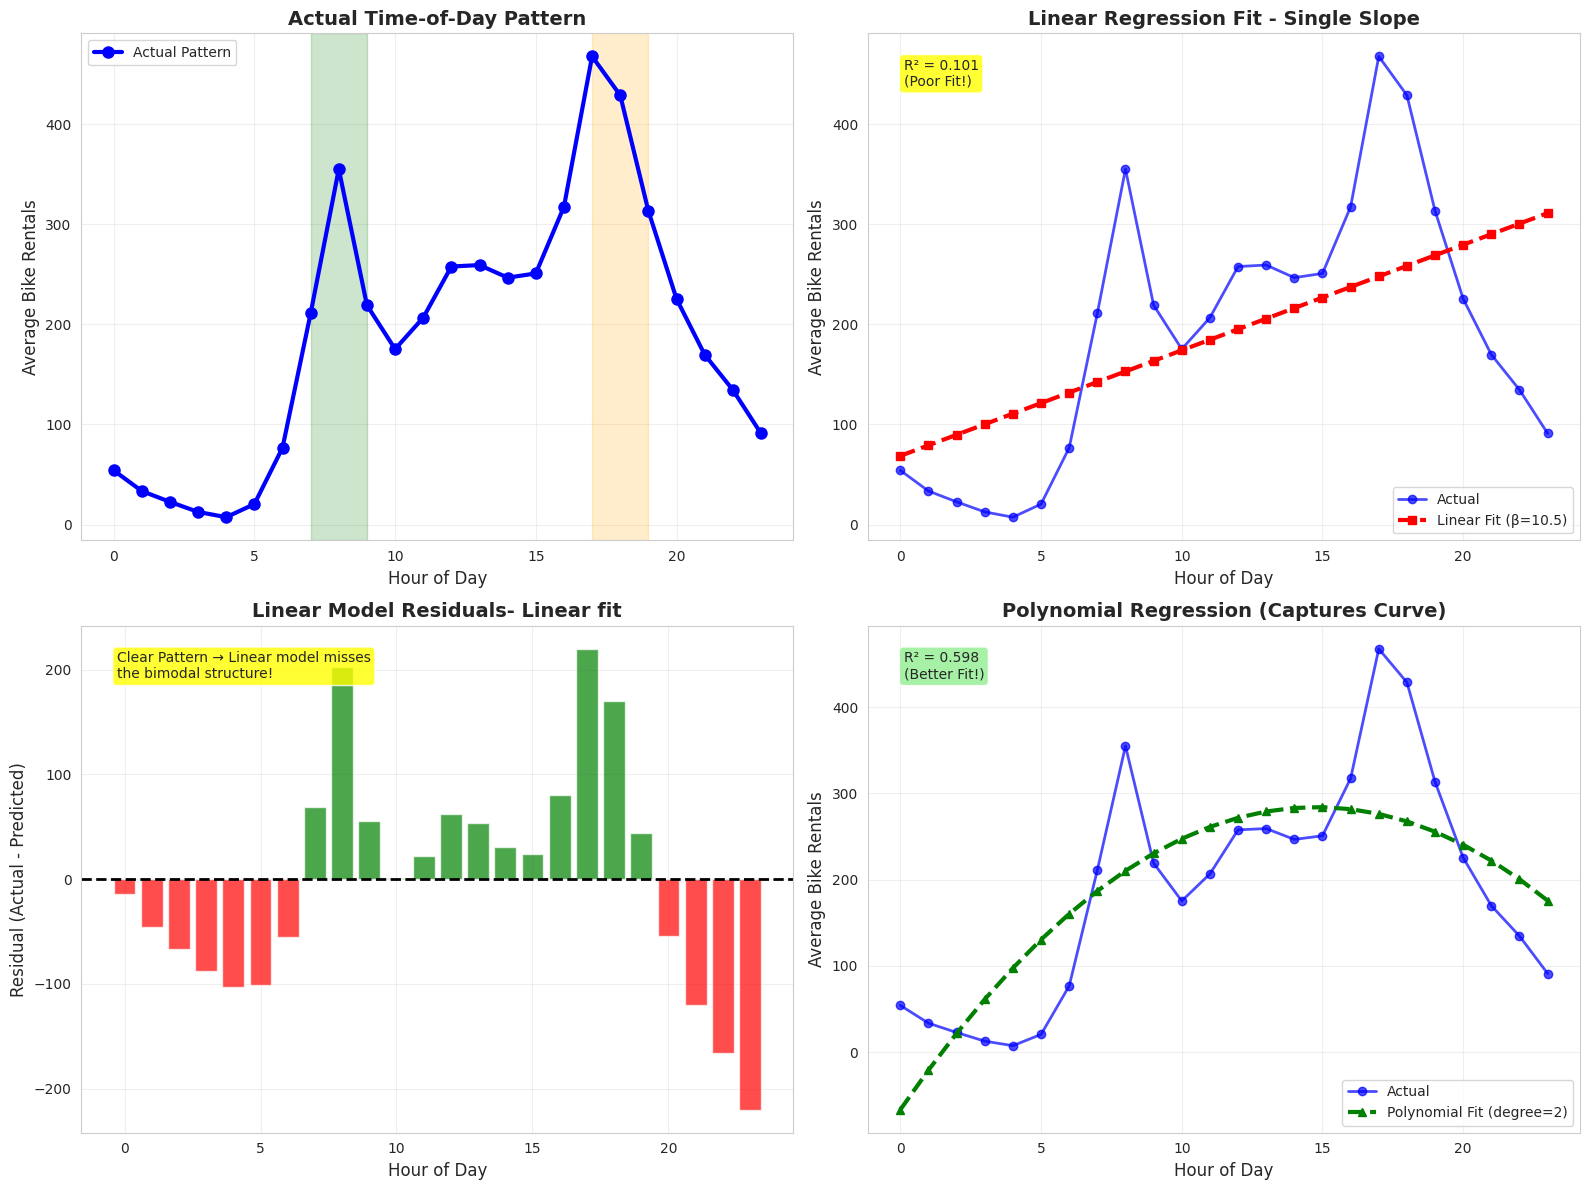

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


axes[0, 0].plot(hourly_avg.index, hourly_avg.values, 'o-', linewidth=3, markersize=8, color='blue', label='Actual Pattern')
axes[0, 0].set_xlabel('Hour of Day', fontsize=12)
axes[0, 0].set_ylabel('Average Bike Rentals', fontsize=12)
axes[0, 0].set_title('Actual Time-of-Day Pattern', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].axvspan(7, 9, alpha=0.2, color='green', label='Morning Peak')
axes[0, 0].axvspan(17, 19, alpha=0.2, color='orange', label='Evening Peak')


X_hour = hourly_avg.index.values.reshape(-1, 1)
y_hour = hourly_avg.values

lin_model = LinearRegression()
lin_model.fit(X_hour, y_hour)

linear_pred = lin_model.predict(X_hour)
slope = lin_model.coef_[0]
intercept = lin_model.intercept_
r_value = lin_model.score(X_hour, y_hour)

axes[0, 1].plot(hourly_avg.index, hourly_avg.values, 'o-', linewidth=2, markersize=6, color='blue', label='Actual', alpha=0.7)
axes[0, 1].plot(hourly_avg.index, linear_pred, 's--', linewidth=3, markersize=6, color='red', label=f'Linear Fit (β={slope:.1f})')
axes[0, 1].set_xlabel('Hour of Day', fontsize=12)
axes[0, 1].set_ylabel('Average Bike Rentals', fontsize=12)
axes[0, 1].set_title('Linear Regression Fit - Single Slope', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].text(0.05, 0.95, f'R² = {r_value**2:.3f}\n(Poor Fit!)', 
                transform=axes[0, 1].transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))


residuals_linear = hourly_avg.values - linear_pred
axes[1, 0].bar(hourly_avg.index, residuals_linear, color=['red' if r < 0 else 'green' for r in residuals_linear], alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Hour of Day', fontsize=12)
axes[1, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=12)
axes[1, 0].set_title('Linear Model Residuals- Linear fit', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].text(0.05, 0.95, 'Clear Pattern → Linear model misses\nthe bimodal structure!', 
                transform=axes[1, 0].transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))


poly = PolynomialFeatures(degree=2, include_bias=False)
X_hour_poly = poly.fit_transform(X_hour)
poly_model = LinearRegression()
lr_poly = LinearRegression()
lr_poly.fit(X_hour_poly, y_hour)
poly_pred = lr_poly.predict(X_hour_poly)


axes[1, 1].plot(hourly_avg.index, hourly_avg.values, 'o-', linewidth=2, markersize=6, color='blue', label='Actual', alpha=0.7)
axes[1, 1].plot(hourly_avg.index, poly_pred, '^--', linewidth=3, markersize=6, color='green', label='Polynomial Fit (degree=2)')
axes[1, 1].set_xlabel('Hour of Day', fontsize=12)
axes[1, 1].set_ylabel('Average Bike Rentals', fontsize=12)
axes[1, 1].set_title('Polynomial Regression (Captures Curve)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
r2_poly = 1 - np.sum((hourly_avg.values - poly_pred)**2) / np.sum((hourly_avg.values - hourly_avg.values.mean())**2)
axes[1, 1].text(0.05, 0.95, f'R² = {r2_poly:.3f}\n(Better Fit!)', 
                transform=axes[1, 1].transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

Linear Regression treats “hour” as a straight numerical variable, so it assumes a single linear increasing or decreasing trend across the day. However, bike demand has a non-linear, cyclical, two-peak pattern (morning & evening peaks). Since Linear Regression can’t bend, curve, or model cyclical behavior, it completely misses the real rise-fall-rise pattern. Capturing time-of-day effects requires polynomial terms, hour-as-category, or sine/cosine cyclical features.

In [49]:
X_test = test_df[features]


if 'poly' in best_model_info:
    X_test_scaled = scaler.transform(X_test)
    poly_transformer = best_model_info['poly']
    X_test_transformed = poly_transformer.transform(X_test_scaled)
    test_predictions = best_model.predict(X_test_transformed)   
else:
    test_predictions = best_model.predict(X_test)


test_predictions = np.maximum(test_predictions, 0)


submission_df = pd.DataFrame({
    'datetime': test_df['datetime'],
    'count_predicted': test_predictions
})


submission_df.to_csv('Submission_30_11_25.csv', index=False)

print(f"\n✓ Predictions generated for {len(test_predictions):,} test samples")
print(f"\nPrediction Statistics:")
print(f"   Min:    {test_predictions.min():.2f}")
print(f"   Max:    {test_predictions.max():.2f}")
print(f"   Mean:   {test_predictions.mean():.2f}")
print(f"   Median: {np.median(test_predictions):.2f}")
print(f"   Std:    {test_predictions.std():.2f}")

print(f"\n✓ Submission file saved: 'Submission_30_11_25.csv'")
print(f"   Ready for leaderboard submission!")

print("\n" + "="*80)


print("\nSample Predictions (first 10 rows):")
print(submission_df.head(10))



✓ Predictions generated for 2,613 test samples

Prediction Statistics:
   Min:    0.00
   Max:    847.94
   Mean:   195.59
   Median: 161.57
   Std:    168.73

✓ Submission file saved: 'Submission_30_11_25.csv'
   Ready for leaderboard submission!


Sample Predictions (first 10 rows):
             datetime  count_predicted
0 2012-06-05 05:00:00         0.000000
1 2011-03-19 19:00:00       160.058901
2 2012-04-02 06:00:00       123.247902
3 2012-07-13 20:00:00       424.296061
4 2011-11-09 19:00:00       248.109608
5 2012-03-10 00:00:00        45.245568
6 2011-05-19 13:00:00       115.915239
7 2011-05-01 08:00:00        84.327294
8 2012-07-07 08:00:00       149.480919
9 2011-05-07 16:00:00       395.787984
